# DBSCAN (밀도를 기반으로 한 군집)

- 밀도 기반의 클러스터링 알고리즘으로 데이터의 밀도를 이용하여 군집을 형성
- 데이터가 빽빽한(고밀도) 지역을 하나의 군집으로 생성을 하고 드문(저밀도) 지역은 노이즈(이상치)로 판단 

- KMeans와는 다르게 군집의 개수를 지정할 필요가 없다. 
- 비선형 구조의 데이터에서도 군집 형성이 가능(원형, 나선형 구조의 데이터의 패턴이 분석 가능)
- 노이즈를 판단함으로 이상치에 대한 자동 감지 
- 스케일링은 일반적으로 사용(Standard, MinMax)

- 매개변수 
    - eps
        - 기본값 : 0.5
        - 두개의 샘플이 같은 군집으로 간주되기 위한 최대의 거리(반경)
        - 스케일링이 된 데이터를 기준으로 한다면 eps는 최대 값이 2정도로 설정 
        - 스케일링이 되지 않은 데이터를 기준으로 한다면서 eps는 피쳐안의 데이터의 범위에 따라서 값이 변한다.
    - min_samples
        - 기본값 : 5
        - 핵심점(core point)으로 판단하기 위한 최소의 샘플의 개수
    - metric
        - 기본값 : euclidean
        - 거리 계산 방식 
    - metric_params
        - 기본값 : None
        - 거리 계산시 추가 인자 설정 
    - algorithm
        - 기본값 : auto
        - 이웃 탐색 알고리즘
        - auto -> 자동 선택, 데이터 특성에 따라 알고리즘 자동 선택 
        - 'ball_tree' -> 고차원 데이터에서 효율적인 거리 탐색(공간 분할 기반) -> 피쳐의 개수가 많은 경우
        - 'kd_tree' -> 저차원 데이터(20차원 이하)에서 매우 빠른 성능
        - 'brute' -> 모든 점 간의 거리를 계산 -> 데이터의 개수가 적은 경우(5000개 미만)
    - leaf_size
        - 기본값 : 30
        - Tree 알고리즘을 사용하는 경우 리프의 크기를 지정 (성능 조절)
- 속성
    - core_sample_indices_
        - 핵심점의 인덱스 목록 
    - components_
        - 핵심점 좌표 배열 
    - labels_
        - 각 데이터의 군집의 라벨 ( 노이즈는 -1로 표시 )
- 메서드
    - fit()
        - 모델의 데이터를 학습
    - predict()
        - 학습된 모델에서 데이터를 예측(군집의 라벨을 반환)

- 동작의 원리 
    1. 핵심점을 생성 ( 각 점에 대해서 이웃점의 개수를 계산 )
    2. 경계점을 생성 ( 핵심점 근처에 데이터가 존재하지만 자신이 핵심이 아닌 경우 )
    3. 노이즈점을 생성 ( 어떠한 군집에도 속하지 않은 데이터 )
    4. 핵심점에서 시작해 이웃을 계속 측정하여 확장하면서 군집 형성 

- 파라미터 튜닝 팁
    - 너무 많은 노이즈가 생성
        - eps 증가 하거나 min_samples 감소 
    - 클러스터(군집)이 너무 뭉치는 경우
        - eps 감소
    - 데이터가 너무 고차원인 경우 
        - 차원 축소를 통해서 고차원 데이터를 저차원으로 변경하고 사용
    - 속도가 너무 느리다
        - algorithm 를 kd_tree로 변경하거나 n_jobs를 -1로 변경

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, \
    davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

In [2]:
# 데이터셋 로드 
df = pd.read_csv("../data/bodyPerformance.csv")

In [4]:
# object형 컬럼의 데이터들을 라벨인코더를 이용하여 수치형 데이터로 변환 
obj_cols =  df.select_dtypes('object').columns.tolist()

for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].values)

In [ ]:
df.head()

In [6]:
# 독립, 종속 데이터 변환 
X = df.drop('class', axis=1).values
Y = df['class'].values
# 독립 데이터는 스케일링 
X_std = StandardScaler().fit_transform(X)

In [16]:
# K번째(10) 최근접 이웃의 거리 계산 
nbrs = NearestNeighbors(n_neighbors=10).fit(X_std)
distances, _ = nbrs.kneighbors(X_std)

distances[:, -1]

array([0.98773763, 1.09658759, 1.16466538, ..., 1.29056459, 1.61649612,
       1.29657021], shape=(13393,))

In [17]:
# 각각의 데이터에서 10번째 이웃의 거리만 추출 
kth_list = np.sort(distances[:, -1])

# eps -> 꺽이는 지점
diffs = np.diff(kth_list)
eps_ = np.where(diffs > 0.05)[0]
eps_

array([13357, 13370, 13371, 13374, 13376, 13378, 13380, 13382, 13383,
       13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391])

In [18]:
print("급변하는 인덱스의 값 : ", eps_)
print( "대략적인 eps의 최적의 값 : ", round( kth_list[ eps_[0] ] ) )

급변하는 인덱스의 값 :  [13357 13370 13371 13374 13376 13378 13380 13382 13383 13384 13385 13386
 13387 13388 13389 13390 13391]
대략적인 eps의 최적의 값 :  3


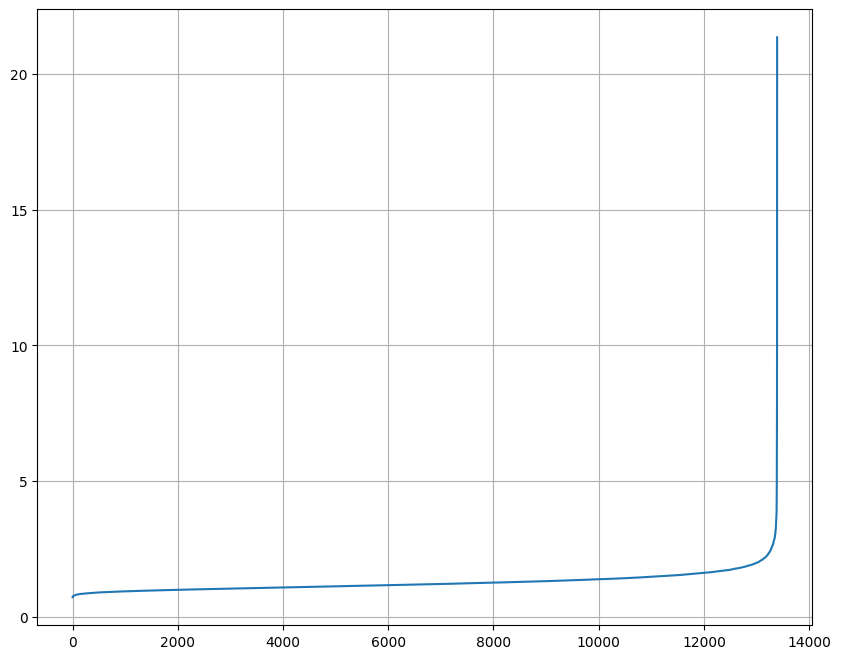

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(kth_list)
plt.grid(True)
plt.show()

In [20]:
eps = 3
min_samples = 10
# 모델 생성
db = DBSCAN(
    eps = eps, 
    min_samples= min_samples, 
    n_jobs= -1
)
# 모델에 데이터 학습 및 예측
labels = db.fit_predict(X_std)

In [23]:
# 라벨의 구성 -> 군집이 여러개인 경우 0, 1, 2, ... / 노이즈 -1
# 라벨의 개수를 확인 
set(labels)

{np.int64(-1), np.int64(0)}